In [94]:
import numpy as np 
import matplotlib.pyplot as plt

In [95]:
def plot_gp(mu, cov, X, samples=[], ax=None):
    X = X.reshape(-1)
    mu = mu.reshape(-1)
    diag = np.diag(cov)
    uncertainty = 1.96 * np.sqrt(diag)

    ax.fill_between(X, mu+ uncertainty, mu - uncertainty, alpha=0.1)
    ax.plot(X, mu, label="Mean")

    for i, sample in enumerate(samples):
        ax.plot(X, sample, lw=1, ls="--", label='sample_{}'.format(i))
    # ax.legend(loc="lower right")

def gaussian_rbf(x1, x2, g_l=1, g_sigma_f=1, **kwargs):
    dist_matrix = np.sum(np.square(x1), axis=1).reshape(-1, 1) + np.sum(np.square(x2), axis=1) - 2 * np.dot(x1, x2.T)
    return np.square(g_sigma_f) * np.exp(-1 / (2 * np.square(g_l)) * dist_matrix)


def linear(x1,x2, l_c1=2, l_c2=2, l_sigma_1=0.1, l_sigma_f=0.1, **kwargs):    
    dist_matarix =  np.dot(x1 -l_c1, (x2-l_c2).T)
    return l_sigma_1 + l_sigma_f * dist_matarix


def posterior_predictive(X, X_train, Y_train, sigma_y=1e-8, **kwargs):
    K = kernel(X_train, X_train, **kwargs) + np.square(sigma_y) * np.eye(len(X_train))
    K_s = kernel(X_train, X, **kwargs)
    K_ss = kernel(X, X, **kwargs)

    K_inv = np.linalg.inv(K)

    mu_s = K_s.T @ K_inv @ Y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s

    return mu_s, cov_s

In [156]:
f1  = np.sin
f2 = lambda x:x + np.random.random(size=x.shape) /10
def f3(x):
    new_x = np.zeros(shape=x.shape)
    if len(new_x) <=2:
        new_x = np.linspace(-2,2, len(new_x))
        return new_x
    for s in range(len(new_x)):
        if x[s] < -2:
            new_x[s] = 0
        elif x[2] < 1 :
            new_x[s] = 0
        else:
            new_x[s] = -0
    return new_x


config = {
    # Uniform samples in [-5 ~ 5] 
    "save_name": "result",
    "num_train" : 4,
    "num_pred" : 50,

    # RBF
    "g_sigma_f" : 0.5,
    "g_l" : 0.3,
    
    # Linear
    "l_c1" :-5,
    "l_c2" :-5,
    "l_sigma_1":0.001,
    "l_sigma_f":0.0005,
    
    # kernel / function 
    "kernels": [gaussian_rbf, linear],
    "functions":[f1,f2,f3]
}
config["save_name"] = config['save_name']+ "_" + "_".join(map(str,[config['num_train'], 
                                                    config["g_sigma_f"],
                                                    config["g_l"],
                                                    config['l_c1'],
                                                    config['l_c2'],
                                                    config['l_sigma_1'], 
                                                    config['l_sigma_f']]))

/var/folders/28/jy8_vfjd7kn3d7khbpw4vjqh0000gn/T/ipykernel_13127/983105543.py:21: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.reshape(-1), cov_s, 5)
/var/folders/28/jy8_vfjd7kn3d7khbpw4vjqh0000gn/T/ipykernel_13127/412552419.py:5: RuntimeWarning: invalid value encountered in sqrt
  uncertainty = 1.96 * np.sqrt(diag)
/var/folders/28/jy8_vfjd7kn3d7khbpw4vjqh0000gn/T/ipykernel_13127/983105543.py:21: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.reshape(-1), cov_s, 5)
/var/folders/28/jy8_vfjd7kn3d7khbpw4vjqh0000gn/T/ipykernel_13127/412552419.py:5: RuntimeWarning: invalid value encountered in sqrt
  uncertainty = 1.96 * np.sqrt(diag)
/var/folders/28/jy8_vfjd7kn3d7khbpw4vjqh0000gn/T/ipykernel_13127/983105543.py:21: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.reshape(-1), cov_s, 5)
/var/folders/28/jy8_vfjd7kn3d7khbpw4v

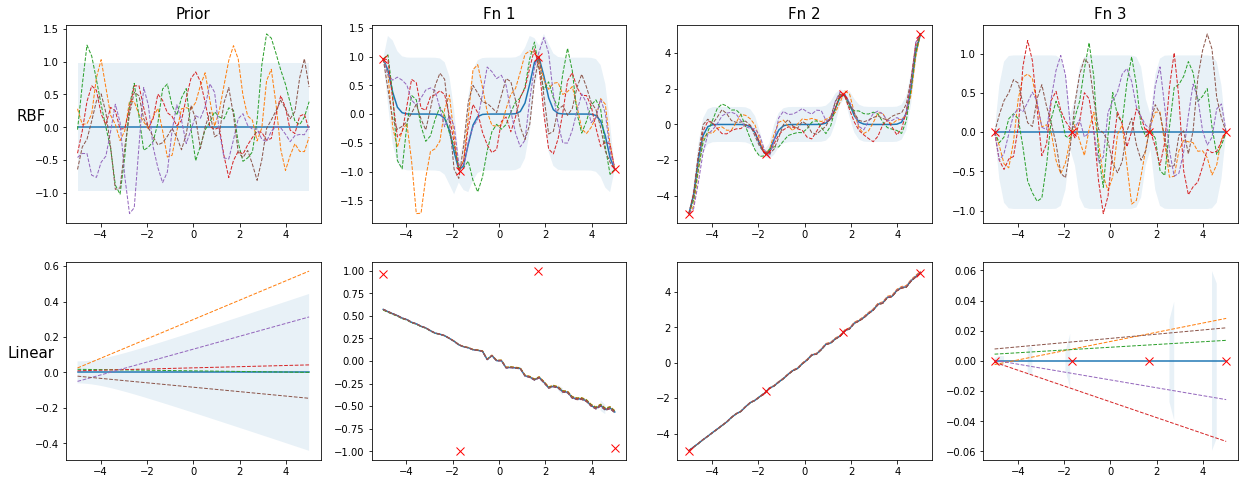

In [157]:
np.random.seed(3)

fig, ax = plt.subplots(2,1+len(config["functions"]), figsize=(7*len(config["functions"]), 8))
for j, kernel in enumerate(config.get("kernels")):
    num_train = config.get("num_train")
    num_pred = config.get("num_pred")
    
    X_pred = np.linspace(-5, 5, num_pred).reshape(-1, 1)
    X_train = np.linspace(-5, 5, num_train).reshape(-1, 1)

    # Predictive Variables and Prior
    mu = np.zeros(X_pred.shape)
    cov = kernel(X_pred, X_pred, **config)
    samples = np.random.multivariate_normal(mu.reshape(-1), cov, 5)
    plot_gp(mu, cov, X_pred, samples, ax=ax[j][0])
    for i, function in enumerate(config['functions']):
        # generate Y and compute posterior
        Y_train = (function(X_train)).reshape(-1, 1) 
        try:
            mu_s, cov_s = posterior_predictive(X_pred, X_train, Y_train, **config)
            samples = np.random.multivariate_normal(mu_s.reshape(-1), cov_s, 5)
            plot_gp(mu_s, cov_s, X_pred, samples, ax=ax[j][1 + i])
            ax[j][1 + i].plot(X_train, Y_train, 'rx', ms=8)
        except Exception as e: 
            print("--------------")
            print("Error: ", e)
            print(kernel, "failed to ")
        # specify training examples 
    
fontsize=15
ax[0][0].set_title("Prior", fontsize=fontsize)
ax[0][1].set_title("Fn 1", fontsize=fontsize)
ax[0][2].set_title("Fn 2", fontsize=fontsize)
ax[0][3].set_title("Fn 3", fontsize=fontsize)
ax[0][0].set_ylabel("RBF", rotation=0, fontsize=fontsize)
ax[1][0].set_ylabel("Linear",rotation=0, fontsize=fontsize)
plt.savefig(config['save_name']+".pdf")
